In [70]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist

from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

In [71]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, alpha= 0.1)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.4 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

### Generate Data

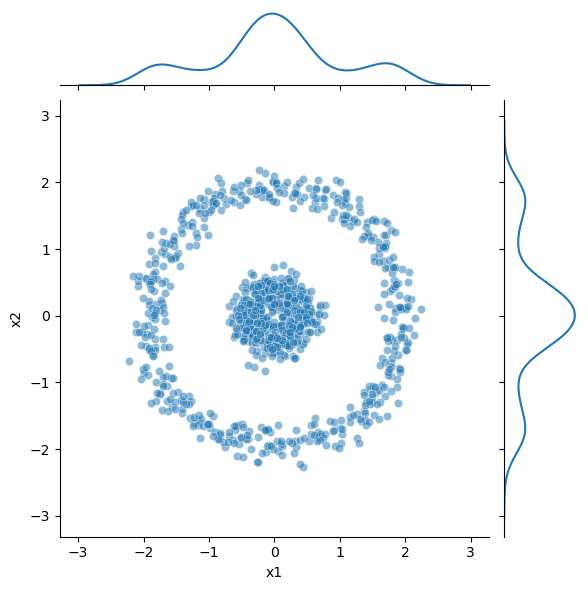

In [74]:
X, y = make_moons(n_samples= 1000, noise= 0.075)

X, y = make_circles(n_samples= 1000, factor= 0.2, noise= 0.075)

X = StandardScaler().fit_transform(X)

df = pd.DataFrame(X, columns= ['x1', 'x2'])
#df['label'] = y

g = sns.JointGrid(data= df, x= 'x1', y= 'x2', height= 6)
g.plot_joint(sns.scatterplot, alpha=.5)
g.plot_marginals(sns.kdeplot);

### Attempt KMeans 

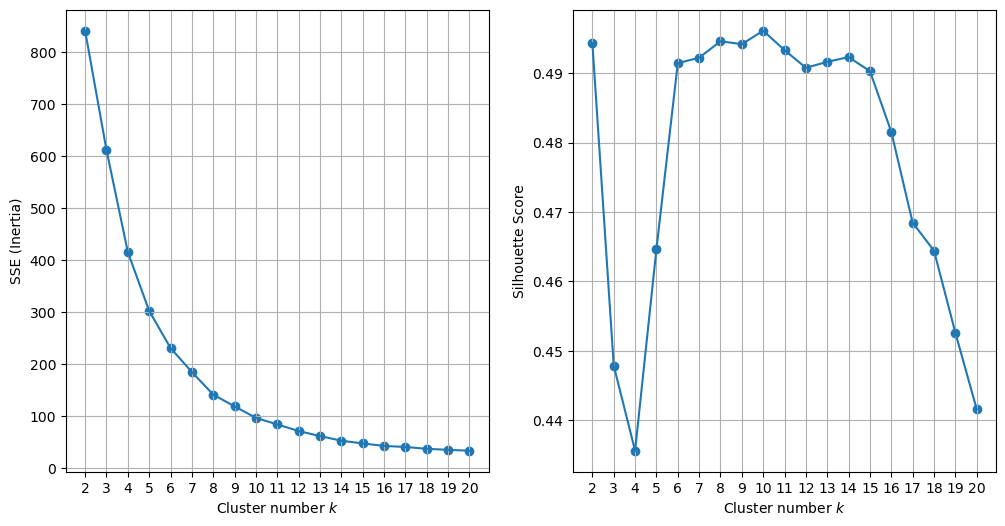

In [49]:
sse_sil = np.empty((0, 3))
for k in np.arange(2, 21, 1):
    kmeans = KMeans(n_clusters= k, n_init= 10)
    kmeans.fit(df)
    labels = kmeans.labels_
    
    sse_sil = np.vstack([sse_sil, 
                         np.array([k, kmeans.inertia_, silhouette_score(df, labels)])])
    
fig, (ax1, ax2) = plt.subplots(nrows= 1, ncols= 2, figsize= (12, 6))

ax1.scatter(x= sse_sil[:, 0], y= sse_sil[:, 1])
ax1.plot(sse_sil[:, 0], sse_sil[:, 1])
ax1.grid()
ax1.set_xlabel('Cluster number $k$')
ax1.set_ylabel('SSE (Inertia)')
ax1.set_xticks(ticks= np.arange(2, 21, 1))

ax2.scatter(x= sse_sil[:, 0], y= sse_sil[:, 2])
ax2.plot(sse_sil[:, 0], sse_sil[:, 2])
ax2.grid()
ax2.set_xlabel('Cluster number $k$')
ax2.set_ylabel('Silhouette Score')
ax2.set_xticks(ticks= np.arange(2, 21, 1))
plt.show()

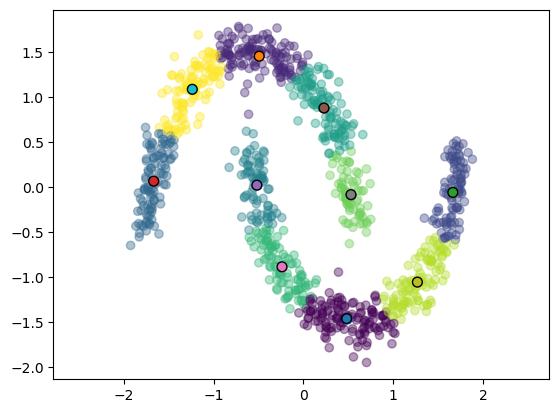

In [50]:
km = KMeans(n_clusters= 10, n_init= 'auto').fit(df)
centers = km.cluster_centers_
labels = km.labels_
    
plt.scatter(x= df.x1, y= df.x2, alpha= 0.4, c= labels)
plt.axis('equal')
for j in np.arange(len(centers)):
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 40)
    plt.scatter(x= centers[j, 0], y= centers[j, 1], marker= 'o', s= 50, edgecolors= 'black', facecolors= 'none')
plt.show()

### Attempt GMM

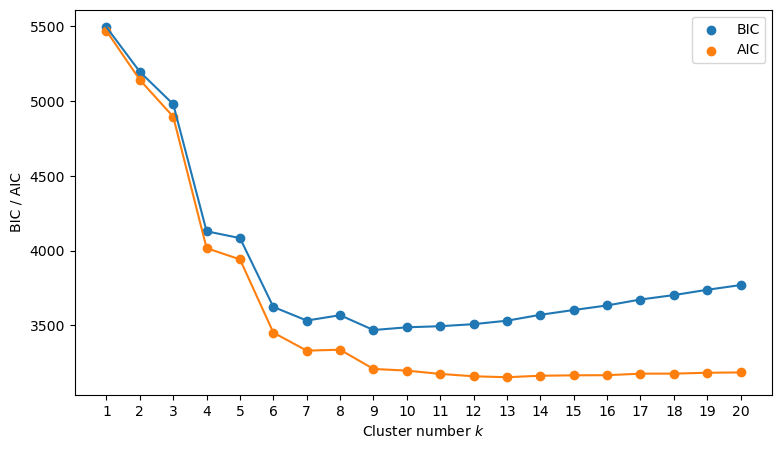

In [51]:
bic_aic = np.empty((0, 3))
for k in np.linspace(1, 20, 20, dtype= int):
    gm = GaussianMixture(n_components= k).fit(df)
    bic_aic = np.vstack([bic_aic, np.array([k, gm.bic(df), gm.aic(df)])]) 
    
    
plt.figure(figsize= (9, 5))
plt.scatter(x= bic_aic[:, 0], y= bic_aic[:, 1], label= 'BIC')
plt.plot(bic_aic[:, 0], bic_aic[:, 1])
plt.scatter(x= bic_aic[:, 0], y= bic_aic[:, 2], label= 'AIC')
plt.plot(bic_aic[:, 0], bic_aic[:, 2])
plt.xlabel('Cluster number $k$')
plt.ylabel('BIC / AIC')
plt.xticks(ticks= np.linspace(1, 20, 20, dtype= int))
plt.legend()
plt.show()

/var/folders/sf/lh5vs79n7sg9l5kff8g_h9zm0000gn/T/ipykernel_45283/277274175.py:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


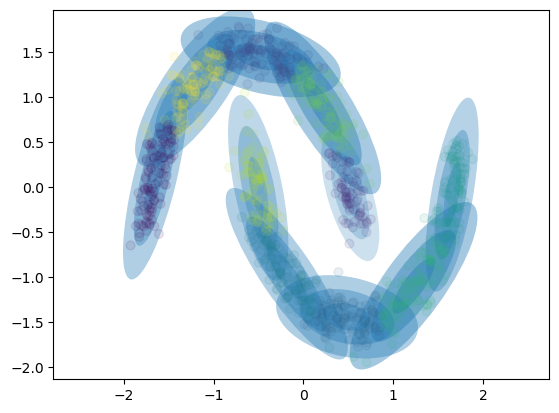

In [52]:
k = 10
gm = GaussianMixture(n_components= k)
gm.fit(df)

plot_gmm(gm, df.values)

### Identify hyperparameters
- Two parameters to the algorithm, min_samples and eps, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster
- min_samples is best set by a domain expert who understands the data well. Unfortunately many cases we don't know the domain knowledge, especially after data is normalized. 
    - One heuristic approach is use ln(n), where n is the total number of points to be clustered.
    - Another approach is to take min_samples >= f + 1, for a 2D dataset, take minPts = 4 or go with 2*D for larger datasets
- eps is evaluated by examing a sorted k-distance elbow plot. 
    - The one parameter you need to define is n_neighbors, which in this case is the value you choose for MinPts


### Quick note on NearestNeighbors

In [29]:
for neighbors in np.arange(2, 6, 1):
    nbrs = NearestNeighbors(n_neighbors= neighbors+1).fit(df)
    distances, indices = nbrs.kneighbors(df)
    print(f'{neighbors} Nearest Neighbors')
    print(distances[:5, :])
    print(distances[:5, 1])
    print()

2 Nearest Neighbors
[[0.         0.03010214 0.05255226]
 [0.         0.01742727 0.06293727]
 [0.         0.07357226 0.08245367]
 [0.         0.02925632 0.0610193 ]
 [0.         0.030785   0.08535033]]
[0.03010214 0.01742727 0.07357226 0.02925632 0.030785  ]

3 Nearest Neighbors
[[0.         0.03010214 0.05255226 0.05272594]
 [0.         0.01742727 0.06293727 0.06706849]
 [0.         0.07357226 0.08245367 0.08600881]
 [0.         0.02925632 0.0610193  0.07169426]
 [0.         0.030785   0.08535033 0.09029286]]
[0.03010214 0.01742727 0.07357226 0.02925632 0.030785  ]

4 Nearest Neighbors
[[0.         0.03010214 0.05255226 0.05272594 0.05357341]
 [0.         0.01742727 0.06293727 0.06706849 0.0742044 ]
 [0.         0.07357226 0.08245367 0.08600881 0.10317899]
 [0.         0.02925632 0.0610193  0.07169426 0.07665627]
 [0.         0.030785   0.08535033 0.09029286 0.09468612]]
[0.03010214 0.01742727 0.07357226 0.02925632 0.030785  ]

5 Nearest Neighbors
[[0.         0.03010214 0.05255226 0.0

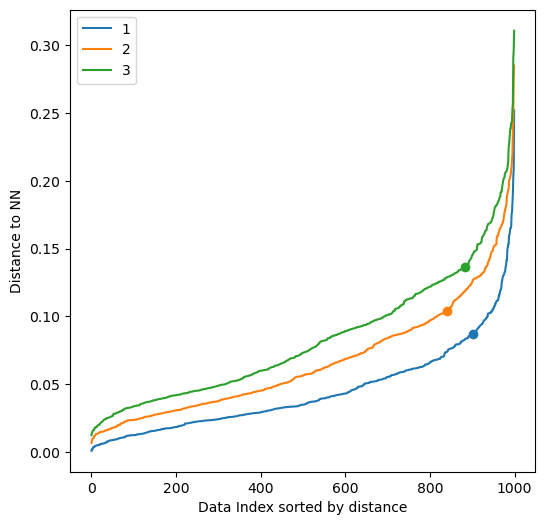

In [79]:
neighbors = 3
nbrs = NearestNeighbors(n_neighbors= neighbors + 1).fit(df)
distances, indices = nbrs.kneighbors(df)
distances= np.sort(distances, axis= 0)


opt_esp_minpts = np.empty((0, 2))
plt.figure(figsize= (6, 6))
for n in np.arange(1, neighbors + 1):
    
    lndf = np.linspace(start= distances[0, n], stop= distances[-1, n], num= int(distances.shape[0]))

    distA = np.concatenate([np.arange(1, distances.shape[0] + 1) / distances.shape[0], distances[:, n]]).reshape(2, -1).T
    distB = np.concatenate([np.arange(1, lndf.shape[0] + 1) / lndf.shape[0], lndf]).reshape(2, -1).T

    all2all = cdist(XA = distA, XB= distB)
    idx_opt = all2all.min(axis= 1).argmax()
    
    opt_esp_minpts = np.vstack([opt_esp_minpts, np.array([n, distances[idx_opt, n]])]) 
    
    plt.plot(distances[:, n], label= n)
    plt.scatter(x= idx_opt, y= distances[idx_opt, n])
    
plt.legend()
plt.xlabel('Data Index sorted by distance')
plt.ylabel('Distance to NN')
plt.show()

### Identifying the optimal ESP

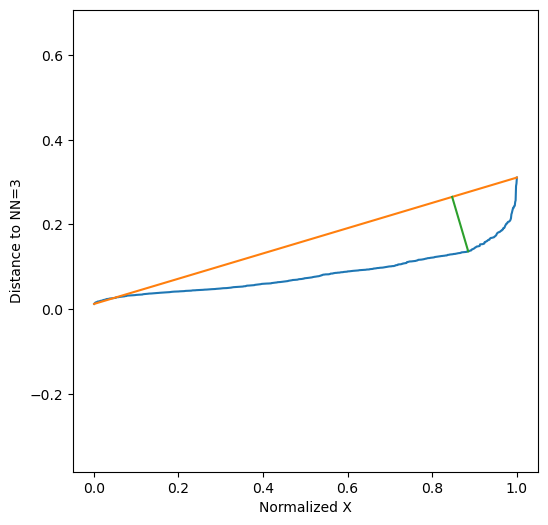

In [80]:
plt.figure(figsize= (6, 6))
plt.plot(distA[:, 0], distA[:, 1])
plt.plot(distB[:, 0], distB[:, 1])
plt.plot(np.vstack([distA[idx_opt], distB[all2all[idx_opt].argmin()]])[:, 0],
         np.vstack([distA[idx_opt], distB[all2all[idx_opt].argmin()]])[:, 1])
plt.xlabel('Normalized X')
plt.ylabel(f'Distance to NN={int(opt_esp_minpts[-1, 0])}')
plt.axis('equal')
plt.show()

### Fit a DBSCAN object

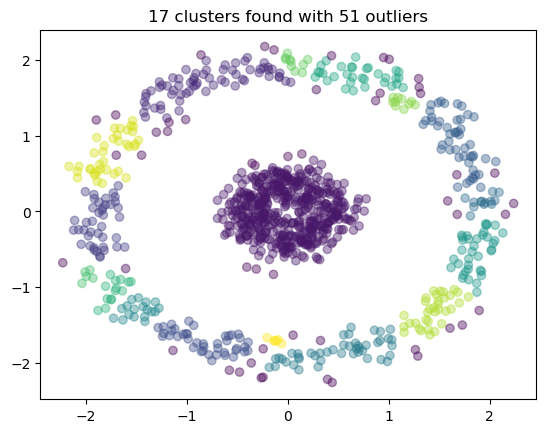

In [81]:
dbscan = DBSCAN(min_samples= int(opt_esp_minpts[-1, 0]) + 1, eps= opt_esp_minpts[-1, 1]).fit(df)
labels_db = dbscan.labels_
clstr, cnts = np.unique(dbscan.labels_, return_counts= True)

plt.scatter(x= df.x1, y= df.x2, c = labels_db, alpha= 0.4)
plt.title(f'{len(np.delete(clstr, [0]))} clusters found with {cnts[0]} outliers')
plt.show()

### Examine Silhouette Scores

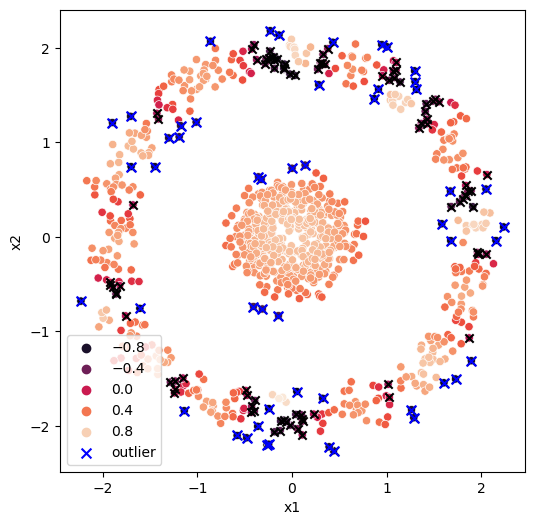

In [82]:
X_df = df.copy()
X_df['silhouette_coefficient']  = silhouette_samples(df, dbscan.labels_)
X_df['label'] = dbscan.labels_

plt.figure(figsize= (6, 6))
sns.scatterplot(x= X_df.x1, y= X_df.x2, hue= X_df.silhouette_coefficient, palette= 'rocket')
plt.scatter(x= X_df[X_df.silhouette_coefficient < 0].x1, y= X_df[X_df.silhouette_coefficient < 0].x2, marker= 'x', color= 'black')
plt.scatter(x= X_df[X_df.label == -1].x1, y= X_df[X_df.label == -1].x2, marker= 'x', s= 50, color= 'blue', label= 'outlier')
plt.legend()
plt.show()

In [83]:
X_df.silhouette_coefficient.mean()

0.40380102474961066

In [84]:
davies_bouldin_score(X= X_df[['x1', 'x2']], labels= X_df.label)

2.639963289322992

In [85]:
calinski_harabasz_score(X= X_df[['x1', 'x2']], labels= X_df.label)

296.0766044359957

### Update distance hyperparameter to qualitative assessment

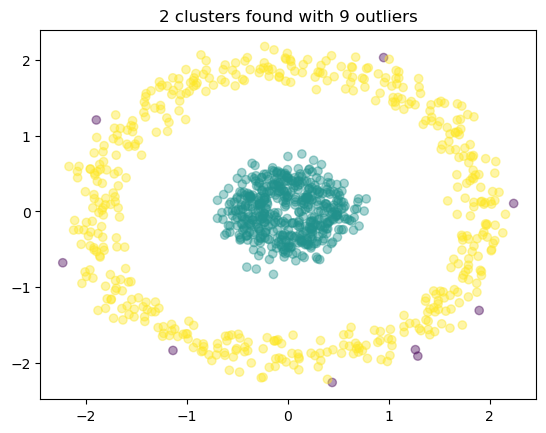

In [95]:
dbscan = DBSCAN(min_samples= 4, eps= 0.19).fit(df)
labels_db = dbscan.labels_
clstr, cnts = np.unique(dbscan.labels_, return_counts= True)

plt.scatter(x= df.x1, y= df.x2, c = labels_db, alpha= 0.4)
plt.title(f'{len(np.delete(clstr, [0]))} clusters found with {cnts[0]} outliers')
plt.show()

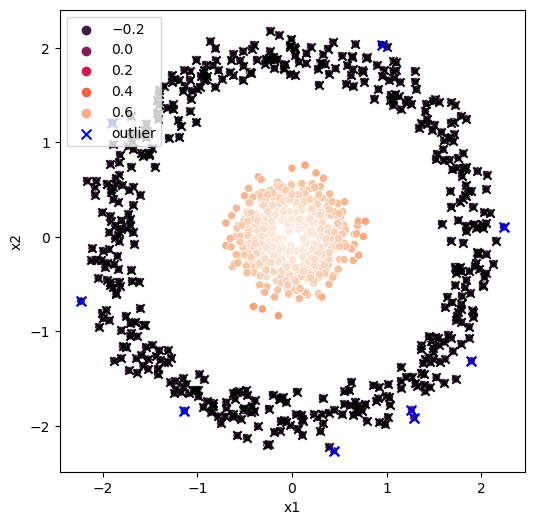

In [96]:
X_df = df.copy()
X_df['silhouette_coefficient']  = silhouette_samples(df, dbscan.labels_)
X_df['label'] = dbscan.labels_

plt.figure(figsize= (6, 6))
sns.scatterplot(x= X_df.x1, y= X_df.x2, hue= X_df.silhouette_coefficient, palette= 'rocket')
plt.scatter(x= X_df[X_df.silhouette_coefficient < 0].x1, y= X_df[X_df.silhouette_coefficient < 0].x2, marker= 'x', color= 'black')
plt.scatter(x= X_df[X_df.label == -1].x1, y= X_df[X_df.label == -1].x2, marker= 'x', s= 50, color= 'blue', label= 'outlier')
plt.legend()
plt.show()

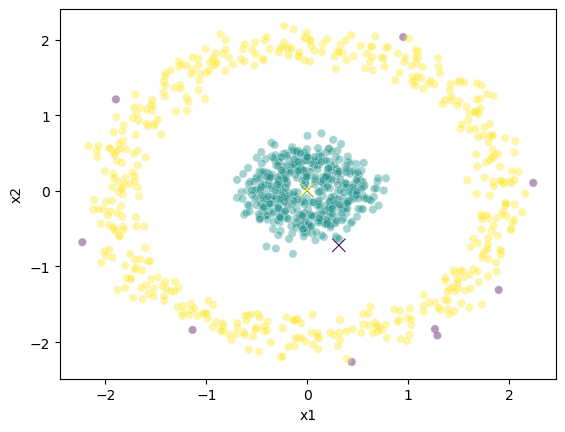

In [97]:
dbscan_centroids = X_df.groupby('label')[['x1', 'x2']].mean().reset_index()
#dbscan_centroids = dbscan_centroids[dbscan_centroids.label > -1]

sns.scatterplot(x= X_df.x1, y= X_df.x2, c= X_df.label, alpha= 0.4)
sns.scatterplot(x= dbscan_centroids.x1, y= dbscan_centroids.x2, marker= 'x', s= 90, c= dbscan_centroids.label)
plt.show()

In [98]:
X_df.silhouette_coefficient.mean()

0.25066819619841546

In [99]:
davies_bouldin_score(X= X_df[['x1', 'x2']], labels= X_df.label)

149.09426599368723

In [100]:
calinski_harabasz_score(X= X_df[['x1', 'x2']], labels= X_df.label)

1.4050256561736696